# Import 

In [1]:
import sys, os
import json
import time
import math

In [2]:
import pandas as pd
import numpy as np

In [3]:
from PIL import Image
from gensim.models import Word2Vec
import spacy

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import random_split

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
sys.path.append('../script')

In [7]:
from img2vec import Img2Vec

# Functions

In [8]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
def to_onehot(labels, n_categories, dtype=torch.float32):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories), dtype=dtype)
    for i, label in enumerate(labels):
        # Subtract 1 from each LongTensor because your
        # indexing starts at 1 and tensor indexing starts at 0
        label = torch.LongTensor(label)
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

# Prepare Data

In [10]:
DATA_FOLDER = '../data'
FILE = 'train.csv'
DATA_PATH = '../data/ml-latest-small'
IMAGE_PATH ='../data/image'

In [11]:
with open('../data/description.txt', 'r') as file:
     exDict = json.load(file)

In [12]:
text = exDict['Description']

In [13]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movies.csv'))

In [14]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 3").drop(columns=['rating', 'timestamp'])

In [15]:
links_df = pd.read_csv(os.path.join(DATA_PATH, 'links.csv'))

In [16]:
n = links_df.shape[0]

In [17]:
imdb2id = {str(links_df.imdbId[i]): links_df.movieId[i] for i in range(n)}
id2imdb = {links_df.movieId[i]: str(links_df.imdbId[i]) for i in range(n)}

In [18]:
idtxt = list(text)
idtxt = [imdb2id[i] for i in idtxt if text[i] != '']

In [19]:
idimg = [imdb2id[i.replace('.jpeg', '')] for i in os.listdir(IMAGE_PATH)]

In [20]:
m_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 10]).index)
u_id = set((ratings_df.userId.value_counts()[ratings_df.userId.value_counts() > 10]).index)
ratings_df.query("movieId in @m_id & userId in @u_id & movieId in @idtxt & movieId in @idimg", inplace=True)

In [21]:
movie_list = [id2imdb[m] for m in ratings_df.movieId.unique()]

In [22]:
nlp = spacy.load("en_core_web_sm")
spacy_sw = spacy.lang.en.stop_words.STOP_WORDS

def fct(doc):
    return ' '.join([w.lemma_ for w in doc 
            if w.lemma_ not in spacy_sw and 
            not w.is_punct and 
            w.tag_ != 'VBN'
           ])

def create_weight(text):
    desc = list(text)
    desc = [d 
            if type(d) is not np.float 
            else 'Nothing' 
            for d in desc]
    docs = nlp.pipe(desc)
    split_d = [fct(doc).split() for doc in docs]
    model_emb_w = Word2Vec(split_d, min_count=10, size=64)
    weights = torch.FloatTensor(model_emb_w.wv.vectors)
    weights = torch.cat((weights, weights.mean(0, keepdim=True)), dim=0)
    return weights, model_emb_w, split_d

In [23]:
npt = [text[i] for i in list(text) if i in movie_list]
weights, model_emb_w, split_d = create_weight(npt)

In [24]:
vocab = list(model_emb_w.wv.vocab)

In [25]:
word2id = [torch.LongTensor([vocab.index(w) for w in s if w in vocab]) for s in split_d]
# the final term is for padding
pad_int = len(vocab)
# padding the input (put this in dataloader)
word2id_pad = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)

In [26]:
resnet_features = Img2Vec()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\micka/.cache\torch\checkpoints\resnet101-5d3b4d8f.pth
100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [02:37<00:00, 1.14MB/s]


In [27]:
vect_img = []
for i in movie_list:
    file = i + '.jpeg'
    img = Image.open(os.path.join(IMAGE_PATH, file))
    if img.mode == 'L':
        img = img.convert('RGB')
    vec = resnet_features.get_vec(img)
    vect_img.append(vec)

In [28]:
matrix_img = np.stack(vect_img, axis=0)

In [29]:
tensor_img = torch.Tensor(matrix_img)

In [30]:
ratings_df['movieId'] = ratings_df.movieId.apply(lambda x: movie_list.index(id2imdb[x]))

In [341]:
def Neg_Sample(x):
    line = (1  - x).nonzero()
    line = line[torch.multinomial(torch.ones(line.size(0)), 15, True)].t()
    return line

In [420]:
class RecoDataset(Dataset):
    def __init__(self, data, itemId, userId):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        list_item = data.groupby(userId).agg(list)[itemId]
        ohe = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        self.neg_samp = torch.cat([self.Neg_Sample(ohe[i]) for i in range(self.n)])
        
    def Neg_Sample(self, x):
        line = (1  - x).nonzero()
        line = line[torch.multinomial(torch.ones(line.size(0)), 15, True)].t()
        return line

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.neg_samp[idx])

In [421]:
split= 0.8

In [422]:
dataset = RecoDataset(ratings_df, 'movieId', 'userId')
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# Algo

In [423]:
class Reco(nn.Module):
    
    def __init__(self, nItem, nUser, dim):
        super(Reco, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)
        self.nnItem = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFusion = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, dim),
        )

        # text
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.fctxt = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, dim)
        )
        
        # image
        self.fcimg = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, dim)
        )
        
        # total
        self.affine_output = nn.Sequential(
            nn.Linear(dim*4, 64),
            nn.ReLU(),
            nn.Linear(64, out_features=1) #out_features=nItem)
        )
        
    def forward(self, item, user, d, img):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFusion(x_mlp)     
        # text layers
        d = self.embedding(d)
        d = d.mean(dim=1)
        d = self.fctxt(d)
        # image layers
        i = self.fcimg(img)
        # concat the three layer
        vector = torch.cat((x_mlp, x_gmf, d, i), dim=1)   
        x = self.affine_output(vector)  
        return x

In [424]:
R = Reco(ratings_df.movieId.max()+1, ratings_df.userId.max()+1, 64)

In [425]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(R.parameters(), lr=0.0001)

In [426]:
all_losses = []
batches = 0

In [427]:
start = time.time()

for epoch in range(4):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, neg_samp = data
        img, d = tensor_img[items], word2id_pad[items]
        
        batch_size = items.size(0)

        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_pos = R(items, users, d, img)
        loss_neg = torch.tensor([0.])
        
        for i_neg in neg_samp.t():
            img_neg, d_neg = tensor_img[i_neg], word2id_pad[i_neg]
            outputs_neg = R(i_neg, users, d_neg, img_neg)
            loss_neg += criterion(outputs_neg, neg_target)
            
        loss = (2* criterion(outputs_pos, pos_target) + loss_neg / 10)/2
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 1000 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), epoch, batches, loss))
        all_losses.append(loss.item())
        batches += 1

print('Finished Training')

0m 0s, 0 0 1.2061
1m 48s, 1 588 1.0359
3m 38s, 2 1176 1.0117
5m 28s, 3 1764 1.0804
Finished Training


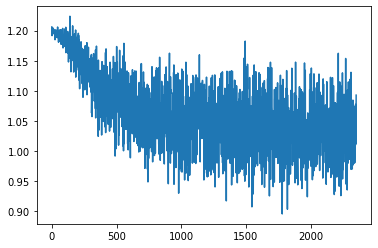

In [429]:
plt.figure()
plt.plot(all_losses)

# Evaluation

In [430]:
correct = 0
correct_neg = 0
correct_pos = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        items, users, neg_samp = data
        img, d = tensor_img[items], word2id_pad[items]
        batch_size = items.size(0)
        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        outputs_pos = R(items, users, d, img)
        loss_neg = torch.tensor([0.])
        for i_neg in neg_samp.t():
            img_neg, d_neg = tensor_img[i_neg], word2id_pad[i_neg]
            outputs_neg = R(i_neg, users, d, img_neg)
            loss_neg += criterion(outputs_neg, neg_target)
            
        total += pos_target.size(0)
        correct_pos += criterion(outputs_pos, pos_target).item()
        correct_neg += (loss_neg / 15.).item()

In [431]:
(correct_pos + correct_neg) / (total*2)

0.009604730302821834

In [432]:
correct_neg / total, correct_pos / total

(0.011781451650094707, 0.007428008955548963)

In [433]:
args = (test_data.dataset.itemId[test_data.indices], 
        test_data.dataset.userId[test_data.indices], 
        word2id_pad[test_data.dataset.itemId[test_data.indices]],
        tensor_img[test_data.dataset.itemId[test_data.indices]],  
       )
n = test_data.dataset.n

In [434]:
sum((nn.Sigmoid()(R(*args))).round()).item() / total

0.7413517828632251

# Recommendation

In [435]:
def reco(user):
    movieid_list = list(ratings_df.movieId.unique())
    movieid_user_list = list(ratings_df[ratings_df.userId == user].movieId)
    items = torch.Tensor([m for m in movieid_list if m not in movieid_user_list]).long()
    size = items.shape[0]
    args_reco = (items, 
        torch.ones(size).long(), 
        word2id_pad[items],
        tensor_img[items],  
       )
    return nn.Sigmoid()(R(*args_reco))

In [436]:
pd.options.mode.chained_assignment = None

In [437]:
user = 63
n_reco = 10
reco_user = reco(user)
reco_top = torch.argsort(reco_user, dim=0, descending=True)[:n_reco].view(n_reco)
score_reco = torch.sort(reco_user, dim=0, descending=True)[0][:n_reco].view(n_reco)
set_reco = [imdb2id[movie_list[i]] for i in reco_top]
a = movies_df.query("movieId in @set_reco")
a['score'] = score_reco.detach().numpy()
set_u = [imdb2id[movie_list[i]] for i in list(ratings_df[ratings_df.userId == user].movieId)]
u_movies = movies_df.query("movieId in @set_u")

In [438]:
u_movies.sample(10)

,movieId,title,genres
7039,68954,Up (2009),Adventure|Animation|Children|Drama
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1158,1527,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8395,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX
1284,1704,Good Will Hunting (1997),Drama|Romance
520,608,Fargo (1996),Comedy|Crime|Drama|Thriller
7323,77455,Exit Through the Gift Shop (2010),Comedy|Documentary
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
5161,8361,"Day After Tomorrow, The (2004)",Action|Adventure|Drama|Sci-Fi|Thriller


In [439]:
a.sample(10)

,movieId,title,genres,score
291,333,Tommy Boy (1995),Comedy,0.911164
325,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,0.906995
1187,1584,Contact (1997),Drama|Sci-Fi,0.892476
115,140,Up Close and Personal (1996),Drama|Romance,0.941544
5911,33679,Mr. & Mrs. Smith (2005),Action|Adventure|Comedy|Romance,0.876488
20,21,Get Shorty (1995),Comedy|Crime|Thriller,0.961484
339,382,Wolf (1994),Drama|Horror|Romance|Thriller,0.901444
116,141,"Birdcage, The (1996)",Comedy,0.916009
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0.961328
275,316,Stargate (1994),Action|Adventure|Sci-Fi,0.915447


In [440]:
u_movies.genres.apply(lambda x: x.split('|')).explode().value_counts(normalize=True)

Action         0.136634
Adventure      0.114851
Drama          0.112871
Comedy         0.106931
Thriller       0.100990
Crime          0.075248
Sci-Fi         0.069307
Animation      0.049505
Fantasy        0.045545
Mystery        0.039604
Children       0.035644
Romance        0.035644
IMAX           0.031683
War            0.017822
Musical        0.009901
Horror         0.007921
Documentary    0.005941
Film-Noir      0.003960
Name: genres, dtype: float64

In [441]:
a.genres.apply(lambda x: x.split('|')).explode().value_counts(normalize=True)

Comedy       0.185185
Action       0.111111
Thriller     0.111111
Drama        0.111111
Romance      0.111111
Crime        0.111111
Sci-Fi       0.074074
Adventure    0.074074
Fantasy      0.037037
Horror       0.037037
Mystery      0.037037
Name: genres, dtype: float64

In [442]:
a.genres.value_counts(normalize=True)[:10]

Comedy                             0.2
Comedy|Crime|Thriller              0.1
Drama|Horror|Romance|Thriller      0.1
Drama|Romance                      0.1
Action|Adventure|Sci-Fi            0.1
Action|Comedy|Crime|Fantasy        0.1
Crime|Mystery|Thriller             0.1
Action|Adventure|Comedy|Romance    0.1
Drama|Sci-Fi                       0.1
Name: genres, dtype: float64

In [443]:
u_movies.genres.value_counts(normalize=True)[:10]

Action|Adventure|Sci-Fi|IMAX     0.026316
Action|Adventure|Sci-Fi          0.026316
Drama|Romance                    0.026316
Crime|Drama                      0.026316
Action|Crime|Thriller            0.026316
Action|Adventure|Thriller        0.026316
Drama                            0.019737
Comedy                           0.019737
Comedy|Crime|Drama|Thriller      0.019737
Drama|Mystery|Sci-Fi|Thriller    0.013158
Name: genres, dtype: float64

(array([ 17.,  32.,  68., 116., 125., 119.,  85.,  87.,  65.,  58.,  65.,
         49.,  36.,  38.,  22.,  32.,  25.,  22.,  21.,  14.,  13.,   4.,
          4.,   5.,   3.]),
 array([0.18817565, 0.21910799, 0.25004032, 0.28097266, 0.31190497,
        0.3428373 , 0.37376964, 0.40470198, 0.43563432, 0.46656665,
        0.49749896, 0.5284313 , 0.55936366, 0.590296  , 0.6212283 ,
        0.65216064, 0.68309295, 0.7140253 , 0.7449576 , 0.77588993,
        0.8068223 , 0.8377546 , 0.868687  , 0.8996193 , 0.93055165,
        0.96148396], dtype=float32),
 <a list of 25 Patch objects>)

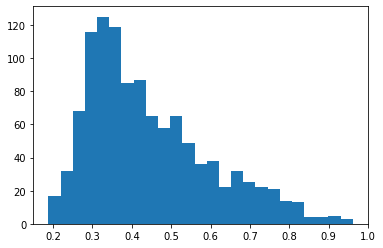

In [444]:
plt.hist(reco_user.detach().numpy()[:,0], bins=25)